## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

<pre>
Github 原碼：LearningRateScheduler 與 ReduceLR

A. LearningRateScheduler

在每個 epoch 開始前，得到目前 lr
根據 schedule function 重新計算 lr，比如 epoch = n 時， new_lr = lr * 0.1
將 optimizer 的 lr 設定為 new_lr
根據 shhedule 函式，假設要自訂的話，它應該吃兩個參數：epoch & lr


B. ReduceLR

在每個 epoch 結束時，得到目前監控目標的數值
如果目標比目前儲存的還要差的話，wait+1；若否則 wait 設為 0，目前監控數值更新新的數值
如果 wait >= patient，new_lr = lr * factor，將 optimizer 的 lr 設定為 new_lr，並且 wait 設回 0
</pre>

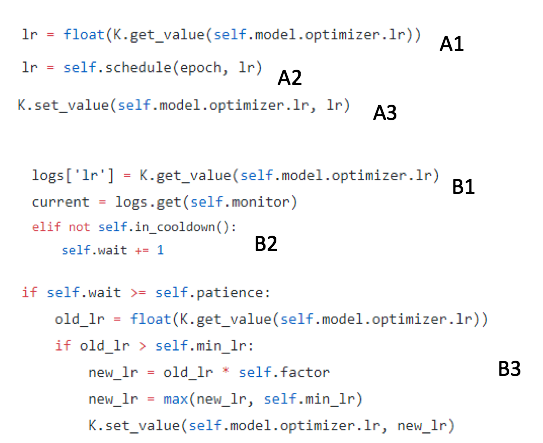

參考連結：

* https://github.com/keras-team/keras/blob/master/keras/callbacks.py#L906
* https://github.com/keras-team/keras/blob/master/keras/callbacks.py#L1287

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

/home/alison/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [10]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.4, 0.5, 0.6]
redice_lr_patient = [5, 10, 15]

In [11]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.40, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalizatio

50000/50000 [==============================] - 6s 115us/step - loss: 2.4089 - acc: 0.2178 - val_loss: 2.1837 - val_acc: 0.2764
Epoch 2/25
50000/50000 [==============================] - 4s 83us/step - loss: 1.9313 - acc: 0.3418 - val_loss: 1.9297 - val_acc: 0.3493
Epoch 3/25
50000/50000 [==============================] - 4s 89us/step - loss: 1.7827 - acc: 0.3839 - val_loss: 1.8210 - val_acc: 0.3784
Epoch 4/25
50000/50000 [==============================] - 4s 75us/step - loss: 1.7009 - acc: 0.4099 - val_loss: 1.7473 - val_acc: 0.3992
Epoch 5/25
50000/50000 [==============================] - 5s 95us/step - loss: 1.6448 - acc: 0.4277 - val_loss: 1.7049 - val_acc: 0.4100
Epoch 6/25
50000/50000 [==============================] - 4s 83us/step - loss: 1.6020 - acc: 0.4417 - val_loss: 1.6666 - val_acc: 0.4219
Epoch 7/25
50000/50000 [==============================] - 4s 85us/step - loss: 1.5646 - acc: 0.4526 - val_loss: 1.6458 - val_acc: 0.4286
Epoch 8/25
50000/50000 [===========================

Epoch 12/25
50000/50000 [==============================] - 4s 80us/step - loss: 1.4491 - acc: 0.4938 - val_loss: 1.5819 - val_acc: 0.4487
Epoch 13/25
50000/50000 [==============================] - 5s 97us/step - loss: 1.4302 - acc: 0.4995 - val_loss: 1.5705 - val_acc: 0.4494
Epoch 14/25
50000/50000 [==============================] - 5s 99us/step - loss: 1.4133 - acc: 0.5072 - val_loss: 1.5619 - val_acc: 0.4543
Epoch 15/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.3956 - acc: 0.5123 - val_loss: 1.5516 - val_acc: 0.4546
Epoch 16/25
50000/50000 [==============================] - 4s 75us/step - loss: 1.3809 - acc: 0.5190 - val_loss: 1.5453 - val_acc: 0.4568
Epoch 17/25
50000/50000 [==============================] - 4s 82us/step - loss: 1.3646 - acc: 0.5245 - val_loss: 1.5391 - val_acc: 0.4600
Epoch 18/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.3509 - acc: 0.5287 - val_loss: 1.5297 - val_acc: 0.4615
Epoch 19/25
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 6s 119us/step - loss: 2.4287 - acc: 0.2182 - val_loss: 2.2132 - val_acc: 0.2731
Epoch 2/25
50000/50000 [==============================] - 4s 80us/step - loss: 1.9294 - acc: 0.3359 - val_loss: 1.9535 - val_acc: 0.3351
Epoch 3/25
50000/50000 [==============================] - 4s 83us/step - loss: 1.7840 - acc: 0.3784 - val_loss: 1.8415 - val_acc: 0.3612
Epoch 4/25
50000/50000 [==============================] - 5s 92us/step - loss: 1.7029 - acc: 0.4034 - val_loss: 1.7630 - val_acc: 0.3856
Epoch 5/25
50000/50000 [==============================] - 4s 82us/step - loss: 1.6482 - acc: 0.4236 - val_loss: 1.7313 - val_acc: 0.3946
Epoch 6/25
50000/50000 [==============================] - 4s 86us/step - loss: 1.6040 - acc: 0.4381 - val_loss: 1.6814 - val_acc: 0.4112
Epoch 7/25
50000/50000 [==============================] - 4s 87us/step - loss: 1.5678 - acc: 0.4502 - val_loss: 1.6594 - val_ac

50000/50000 [==============================] - 4s 88us/step - loss: 0.4986 - acc: 0.8482 - val_loss: 1.5231 - val_acc: 0.5218

Epoch 00023: ReduceLROnPlateau reducing learning rate to 6.40000042039901e-05.
Epoch 24/25
50000/50000 [==============================] - 5s 91us/step - loss: 0.4628 - acc: 0.8671 - val_loss: 1.4855 - val_acc: 0.5352
Epoch 25/25
50000/50000 [==============================] - 4s 77us/step - loss: 0.4526 - acc: 0.8716 - val_loss: 1.4813 - val_acc: 0.5367
Numbers of exp: 10, reduce_factor: 0.40, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_31 (Batc (None, 256)               1024   

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 9s 178us/step - loss: 1.9858 - acc: 0.3282 - val_loss: 1.9301 - val_acc: 0.3546
Epoch 2/25
50000/50000 [==============================] - 5s 94us/step - loss: 1.6290 - acc: 0.4277 - val_loss: 1.7113 - val_acc: 0.3995
Epoch 3/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.5328 - acc: 0.4623 - val_loss: 1.6456 - val_acc: 0.4143
Epoch 4/25
50000/50000 [==============================] - 5s 95us/step - loss: 1.4715 - acc: 0.4844 - val_loss: 1.5961 - val_acc: 0.4329
Epoch 5/25
50000/50000 [==============================] - 4s 86us/step - loss: 1.4239 - acc: 0.5011 - val_loss: 1.5777 - val_acc: 0.4356
Epoch 6/25
50000/50000 [==============================] - 4s 89us/step - loss: 1.3882 - acc: 0.5128 - val_loss: 1.5247 - val_acc: 0.4618
Epoch 7/25
50000/50000 [==============================] - 4s 84us/step - loss: 1.3564 - acc: 0.5264 - val_loss: 1.5111 - val_ac

Epoch 12/25
50000/50000 [==============================] - 5s 96us/step - loss: 1.2371 - acc: 0.5721 - val_loss: 1.4707 - val_acc: 0.4825
Epoch 13/25
50000/50000 [==============================] - 4s 87us/step - loss: 1.2173 - acc: 0.5798 - val_loss: 1.4562 - val_acc: 0.4892
Epoch 14/25
50000/50000 [==============================] - 4s 90us/step - loss: 1.2002 - acc: 0.5854 - val_loss: 1.4587 - val_acc: 0.4890
Epoch 15/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.1845 - acc: 0.5924 - val_loss: 1.4668 - val_acc: 0.4838
Epoch 16/25
50000/50000 [==============================] - 5s 92us/step - loss: 1.1697 - acc: 0.5976 - val_loss: 1.4563 - val_acc: 0.4872
Epoch 17/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.1551 - acc: 0.6035 - val_loss: 1.4421 - val_acc: 0.4976
Epoch 18/25
50000/50000 [==============================] - 5s 93us/step - loss: 1.1406 - acc: 0.6091 - val_loss: 1.4512 - val_acc: 0.4916
Epoch 19/25
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 7s 145us/step - loss: 1.8331 - acc: 0.3678 - val_loss: 2.0529 - val_acc: 0.3302
Epoch 2/25
50000/50000 [==============================] - 5s 95us/step - loss: 1.5384 - acc: 0.4560 - val_loss: 2.0166 - val_acc: 0.3481
Epoch 3/25
50000/50000 [==============================] - 4s 85us/step - loss: 1.4219 - acc: 0.4974 - val_loss: 2.0538 - val_acc: 0.3340
Epoch 4/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.3435 - acc: 0.5249 - val_loss: 1.9752 - val_acc: 0.3200
Epoch 5/25
50000/50000 [==============================] - 4s 74us/step - loss: 1.2699 - acc: 0.5533 - val_loss: 2.0234 - val_acc: 0.3507
Epoch 6/25
50000/50000 [==============================] - 4s 83us/step - loss: 1.2193 - acc: 0.5688 - val_loss: 4.3495 - val_acc: 0.1778
Epoch 7/25
50000/50000 [==============================] - 4s 85us/step - loss: 1.1647 - acc: 0.5882 - val_loss: 1.7142 - val_ac

50000/50000 [==============================] - 4s 80us/step - loss: 0.8082 - acc: 0.7328 - val_loss: 1.6577 - val_acc: 0.4448
Epoch 24/25
50000/50000 [==============================] - 4s 89us/step - loss: 0.7831 - acc: 0.7408 - val_loss: 1.6686 - val_acc: 0.4578
Epoch 25/25
50000/50000 [==============================] - 5s 91us/step - loss: 0.7643 - acc: 0.7481 - val_loss: 1.7378 - val_acc: 0.4515
Numbers of exp: 20, reduce_factor: 0.40, reduce_patient: 15
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_61 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_lay

Epoch 11/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.1169 - acc: 0.6138 - val_loss: 1.5744 - val_acc: 0.4491
Epoch 12/25
50000/50000 [==============================] - 4s 90us/step - loss: 1.0857 - acc: 0.6247 - val_loss: 1.7067 - val_acc: 0.4146
Epoch 13/25
50000/50000 [==============================] - 4s 86us/step - loss: 1.0563 - acc: 0.6348 - val_loss: 1.6449 - val_acc: 0.4361
Epoch 14/25
50000/50000 [==============================] - 4s 87us/step - loss: 1.0280 - acc: 0.6444 - val_loss: 1.7079 - val_acc: 0.4209
Epoch 15/25
50000/50000 [==============================] - 4s 87us/step - loss: 0.9976 - acc: 0.6567 - val_loss: 1.5363 - val_acc: 0.4754
Epoch 16/25
50000/50000 [==============================] - 4s 86us/step - loss: 0.9762 - acc: 0.6661 - val_loss: 1.5097 - val_acc: 0.4795
Epoch 17/25
50000/50000 [==============================] - 4s 87us/step - loss: 0.9520 - acc: 0.6734 - val_loss: 1.8051 - val_acc: 0.4153
Epoch 18/25
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 8s 165us/step - loss: 2.0513 - acc: 0.3087 - val_loss: 2.0261 - val_acc: 0.3315
Epoch 2/25
50000/50000 [==============================] - 5s 91us/step - loss: 1.7289 - acc: 0.3995 - val_loss: 1.8453 - val_acc: 0.3683
Epoch 3/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.6017 - acc: 0.4429 - val_loss: 1.7429 - val_acc: 0.4012
Epoch 4/25
50000/50000 [==============================] - 4s 86us/step - loss: 1.5220 - acc: 0.4695 - val_loss: 1.6606 - val_acc: 0.4225
Epoch 5/25
50000/50000 [==============================] - 4s 86us/step - loss: 1.4574 - acc: 0.4920 - val_loss: 1.6950 - val_acc: 0.4082
Epoch 6/25
50000/50000 [==============================] - 5s 93us/step - loss: 1.4061 - acc: 0.5116 - val_loss: 1.6260 - val_acc: 0.4307
Epoch 7/25
50000/50000 [==============================] - 5s 96us/step - loss: 1.3633 - acc: 0.5273 - val_loss: 1.5982 - val_ac

Epoch 11/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.3532 - acc: 0.5294 - val_loss: 1.5536 - val_acc: 0.4601
Epoch 12/25
50000/50000 [==============================] - 5s 94us/step - loss: 1.3287 - acc: 0.5392 - val_loss: 1.5491 - val_acc: 0.4624
Epoch 13/25
50000/50000 [==============================] - 4s 85us/step - loss: 1.3042 - acc: 0.5481 - val_loss: 1.5305 - val_acc: 0.4616
Epoch 14/25
50000/50000 [==============================] - 4s 90us/step - loss: 1.2818 - acc: 0.5562 - val_loss: 1.5250 - val_acc: 0.4670
Epoch 15/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.2598 - acc: 0.5643 - val_loss: 1.5172 - val_acc: 0.4695
Epoch 16/25
50000/50000 [==============================] - 5s 95us/step - loss: 1.2398 - acc: 0.5727 - val_loss: 1.4983 - val_acc: 0.4761
Epoch 17/25
50000/50000 [==============================] - 4s 84us/step - loss: 1.2195 - acc: 0.5787 - val_loss: 1.5256 - val_acc: 0.4678
Epoch 18/25
50000/50000 [=========

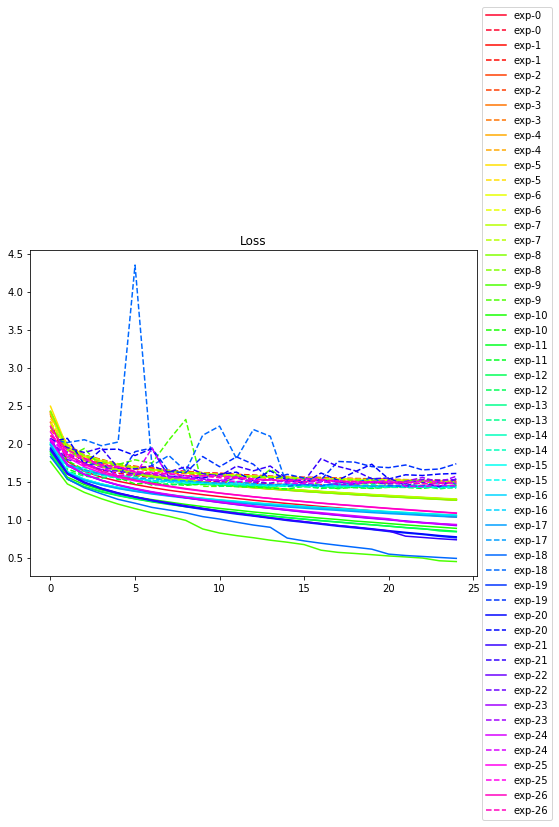

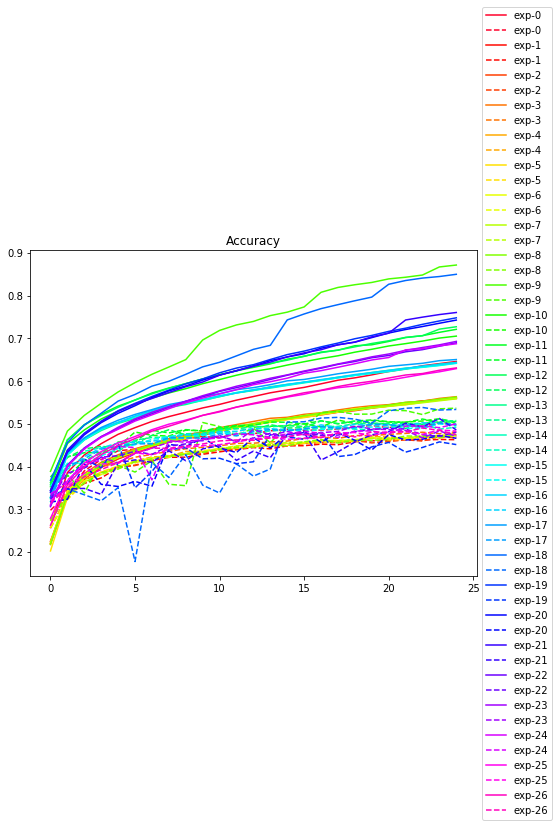

In [12]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()